# Exploratory Data Analysis (EDA) and data cleaning notebook #

**Importing libraries and modules**

In [32]:
# importing external libraries
from pathlib import Path
import os
import pandas as pd
import pickle
import json
import matplotlib.pyplot as plt
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn import set_config
set_config(transform_output = "pandas")

# Importing function to load data

# Making sure any changes are instantly added
%load_ext autoreload
%autoreload 2

from Modules.load_data import load_data
from Modules.preprocessing import missing_summary, merge_dfs, dollar_to_int, find_unique_values
from Modules.plotting import Plotter
from Modules.transforming import *

# Importing Pipelines
from Pipelines.Pipeline1 import Pipeline_for_exploration, Pipeline1, reduction_pipeline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Please unhash and run the cell below if you have not yet installed the dataset using the kaggle API

In [2]:
#load_data()

In [3]:
# Obtaining absolute path to data folder

data_folder = str(Path(os.getcwd()) / "data")

# Obtaining absolute paths to relevant datasets

cards_data = data_folder + "/cards_data.csv"
transaction_data = data_folder + "/transactions_data.csv"

In [4]:
# Merging cards and transactions df and saving to pickle
# Unhash if this is the first time running the code

# Reading datasets into pandas
# cards_data_df = pd.read_csv(cards_data)
# transaction_data_df = pd.read_csv(transaction_data)

# merge_dfs(transaction_data_df=transaction_data_df, cards_data_df=cards_data_df,data_folder=data_folder)

In [5]:
# Loading the data from pickle

merged_df = pd.read_pickle(data_folder + "/merged_data.pkl")

In [6]:
# Viewing head of merged_df
display(merged_df.head())

,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,...,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web,id,target
0,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,...,07/2022,306,YES,2,$55,05/2008,2008,No,7475327,No
1,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,...,12/2024,438,YES,1,$9100,09/2005,2015,No,7475328,No
2,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,...,05/2020,256,YES,1,$14802,01/2006,2008,No,7475329,No
3,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,...,01/2020,120,YES,1,$19113,07/2009,2014,No,7475332,No
4,2010-01-01 00:07:00,1807,165,$4.81,Swipe Transaction,20519,Bronx,NY,10464.0,5942,...,03/2014,198,YES,1,$89,01/2008,2015,No,7475333,No


In [7]:
# Running info to see column types
merged_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914963 entries, 0 to 8914962
Data columns (total 24 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   date                   object 
 1   client_id              int64  
 2   card_id                int64  
 3   amount                 object 
 4   use_chip               object 
 5   merchant_id            int64  
 6   merchant_city          object 
 7   merchant_state         object 
 8   zip                    float64
 9   mcc                    int64  
 10  errors                 object 
 11  card_brand             object 
 12  card_type              object 
 13  card_number            int64  
 14  expires                object 
 15  cvv                    int64  
 16  has_chip               object 
 17  num_cards_issued       int64  
 18  credit_limit           object 
 19  acct_open_date         object 
 20  year_pin_last_changed  int64  
 21  card_on_dark_web       object 
 22  id                

* As we can see a lot of columns that should be numerical are objects as they have dollar signs.
* A lot of columns need to be made numerical
* Dates to be represented as ordered time series

In [8]:
# Running the dollar_to_int function
dollar_to_int(merged_df)

In [9]:
# Running .info() again
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914963 entries, 0 to 8914962
Data columns (total 24 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   date                   object 
 1   client_id              int64  
 2   card_id                int64  
 3   amount                 int64  
 4   use_chip               object 
 5   merchant_id            int64  
 6   merchant_city          object 
 7   merchant_state         object 
 8   zip                    float64
 9   mcc                    int64  
 10  errors                 object 
 11  card_brand             object 
 12  card_type              object 
 13  card_number            int64  
 14  expires                object 
 15  cvv                    int64  
 16  has_chip               object 
 17  num_cards_issued       int64  
 18  credit_limit           int64  
 19  acct_open_date         object 
 20  year_pin_last_changed  int64  
 21  card_on_dark_web       object 
 22  id                

* `amount` and `credit limit` now changed to int types


In [10]:
# Running describe
merged_df.describe()

,client_id,card_id,amount,merchant_id,zip,mcc,card_number,cvv,num_cards_issued,credit_limit,year_pin_last_changed,id
count,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,7.807586e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06
mean,1.026637e+03,3.474887e+03,4.252761e+01,4.772566e+04,5.132855e+04,5.565097e+03,4.817349e+15,4.953292e+02,1.522064e+00,1.554959e+04,2.011340e+03,1.558473e+07
std,5.816755e+02,1.674427e+03,8.151282e+01,2.581623e+04,2.940518e+04,8.755078e+02,1.311465e+15,2.885735e+02,5.151711e-01,1.218199e+04,2.894518e+00,4.703991e+06
min,0.000000e+00,0.000000e+00,-5.000000e+02,1.000000e+00,1.001000e+03,1.711000e+03,3.001055e+14,0.000000e+00,1.000000e+00,0.000000e+00,2.002000e+03,7.475327e+06
25%,5.190000e+02,2.413000e+03,8.000000e+00,2.588700e+04,2.860100e+04,5.300000e+03,4.489873e+15,2.470000e+02,1.000000e+00,8.100000e+03,2.010000e+03,1.150786e+07
50%,1.070000e+03,3.584000e+03,2.800000e+01,4.592600e+04,4.771000e+04,5.499000e+03,5.112842e+15,4.990000e+02,2.000000e+00,1.345500e+04,2.011000e+03,1.557140e+07
75%,1.530000e+03,4.899000e+03,6.300000e+01,6.757000e+04,7.790100e+04,5.812000e+03,5.566696e+15,7.400000e+02,2.000000e+00,2.083900e+04,2.013000e+03,1.965387e+07
max,1.998000e+03,6.138000e+03,6.613000e+03,1.003420e+05,9.992800e+04,9.402000e+03,6.994218e+15,9.990000e+02,3.000000e+00,1.413910e+05,2.020000e+03,2.376187e+07


* No outliers stand out

In [11]:
# Running missing summary
missing_summary(merged_df)

,Missing Values,Percentage missing (%)
date,0,0.000000
client_id,0,0.000000
card_id,0,0.000000
amount,0,0.000000
use_chip,0,0.000000
merchant_id,0,0.000000
merchant_city,0,0.000000
merchant_state,1047865,11.754003
zip,1107377,12.421555
mcc,0,0.000000


In [12]:
merged_df["errors"][merged_df["errors"].notna()]


161              Bad Expiration
180             Bad Card Number
262        Insufficient Balance
319        Insufficient Balance
320        Insufficient Balance
                   ...         
8914572    Insufficient Balance
8914610    Insufficient Balance
8914635    Insufficient Balance
8914782                 Bad PIN
8914898    Insufficient Balance
Name: errors, Length: 141767, dtype: object

* A lot of missing values for `errors` column. A missing value likely to mean there was no transaction error. So will take its own categorical encoding
* `zip` and `merchant_state` have a lot of missing values. These will also take their own categorical encoding in so much as this information may not be disclosed to hide fradulent transactions ...

In [13]:
find_unique_values(merged_df)

,columns,unique_no,unique_%
0,date,3680988,41.29
1,client_id,1219,0.01
2,card_id,4070,0.05
3,amount,2511,0.03
4,use_chip,3,0.00
5,merchant_id,66537,0.75
6,merchant_city,12173,0.14
7,merchant_state,199,0.00
8,zip,24586,0.28
9,mcc,109,0.00


* Due to the large number of categories for categorical variables, target encoding will be used for the first Pipeline
* For features with less categories, such as `card_brand` and `card_type`, one-hot encoding will be used


### Plots of Data

In [14]:
# Creating instance of plotter class
plot_data = Plotter(df=merged_df)

In [15]:
plot_data.display_target(target="target")

,Response,Frequency,Percentage
0,No,8901631,99.85
1,Yes,13332,0.15


We see a huge data disparity in the target variable, henceforth we will need to use different performance metrics to accuracy. We also need to do ensure a good distribution of responses in the train and test set.

In [27]:
df_explore = Pipeline_for_exploration.fit_transform(merged_df)

/home/as3620/FODS_coursework/LoanPrediction/Modules/transforming.py:53: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return pd.to_datetime(X).to_frame()
/home/as3620/FODS_coursework/LoanPrediction/Modules/transforming.py:53: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return pd.to_datetime(X).to_frame()


In [33]:
test = reduction_pipeline.fit_transform(merged_df)

/home/as3620/FODS_coursework/LoanPrediction/Modules/transforming.py:53: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return pd.to_datetime(X).to_frame()
/home/as3620/FODS_coursework/LoanPrediction/Modules/transforming.py:53: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return pd.to_datetime(X).to_frame()


In [35]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102348 entries, 0 to 102347
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   date                   102348 non-null  int64  
 1   acct_open_date         102348 non-null  int64  
 2   expires                102348 non-null  int64  
 3   client_id              102348 non-null  int64  
 4   card_id                102348 non-null  int64  
 5   amount                 102348 non-null  int64  
 6   use_chip               102348 non-null  object 
 7   merchant_id            102348 non-null  int64  
 8   merchant_city          102348 non-null  object 
 9   merchant_state         102348 non-null  object 
 10  zip                    102348 non-null  float64
 11  mcc                    102348 non-null  int64  
 12  errors                 102348 non-null  object 
 13  card_brand             102348 non-null  object 
 14  card_type              102348 non-nu

### Plotting

In [28]:
# Plotter instance
plotter = Plotter(df=df_explore)

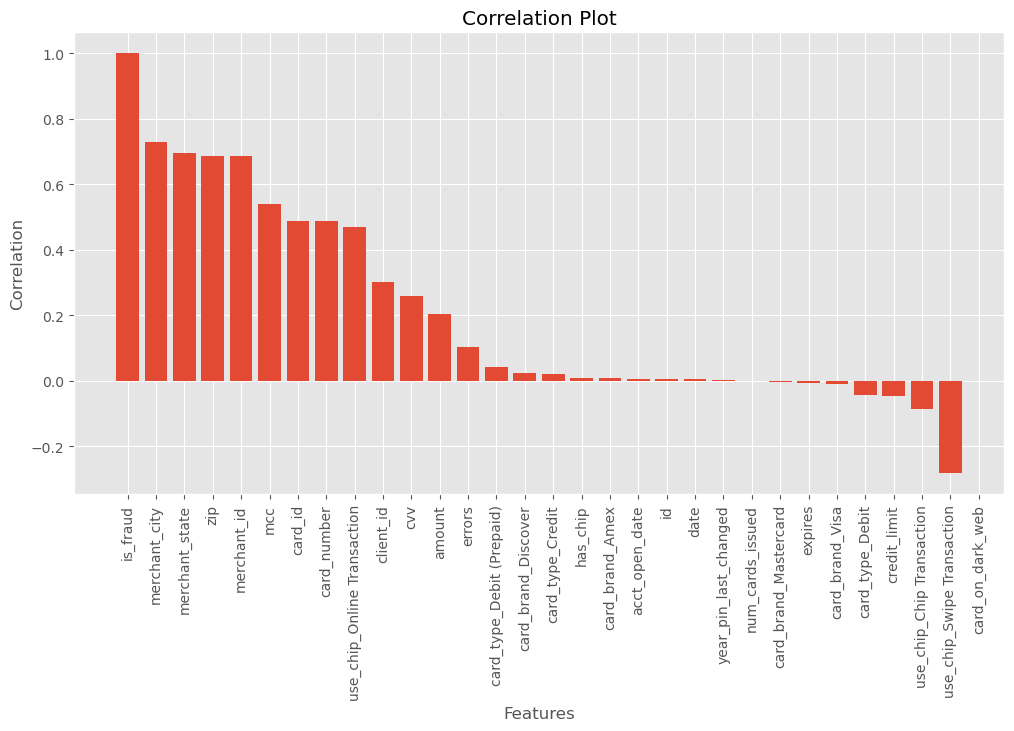

In [29]:
plotter.plot_correlations()

As we can see there are many features with almost no correlation. Lets remove those features with <0.05 correlation!

In [ ]:
df1 = Pipeline1.fit_transform(merged_df)

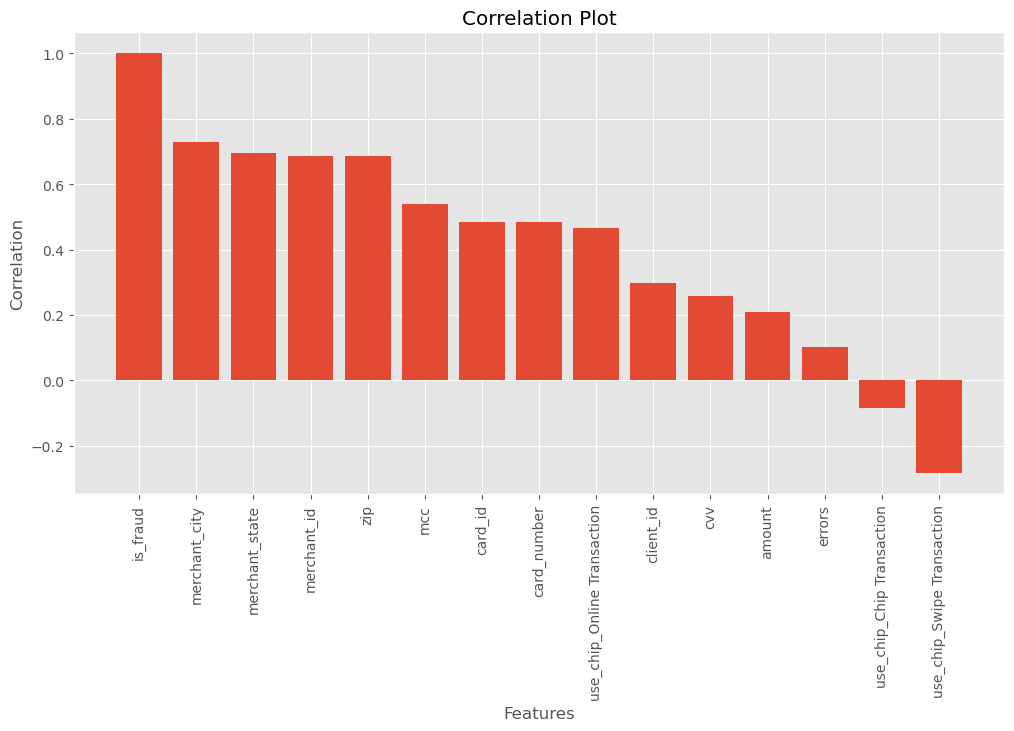

In [31]:
plotter1 = Plotter(df=df1)
plotter1.plot_correlations()